# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [91]:
# all imports and magic commands
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline


### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [105]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [107]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
    X_hv = hv.fit_transform(toxic_data.comment_text)
    print("Shape of HashingVectorizer X:")
    print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    transformer = TfidfTransformer()
    X_tfidf = transformer.fit_transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")
    # Additional Features   
    
    

    X_quant_features = toxic_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    sc = StandardScaler(with_mean=False)
    X = sc.fit_transform(X_matrix)
    print(X.shape)
    if (not test):
        y = toxic_data['any_toxic']
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [95]:
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='/Users/leekuczewski/Desktop/The_New_School/Repos/VisualizeData_MachineLearning/visualizedata-ml/toxiccomments_train.csv', my_random_seed=337)

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [108]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 12971, 'Neg': 114685, 'TP': 6936, 'TN': 55377, 'FP': 59308, 'FN': 6035, 'Accuracy': 0.4881321677006956, 'Precision': 0.10470382223295695, 'Recall': 0.5347313237221494, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [109]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 12971, 'Neg': 114685, 'TP': 12905, 'TN': 114621, 'FP': 64, 'FN': 66, 'Accuracy': 0.9989816381525349, 'Precision': 0.9950651553704989, 'Recall': 0.9949117261583532, 'desc': 'svm_train'}


### MODEL: logistic regression

In [110]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 12971, 'Neg': 114685, 'TP': 12888, 'TN': 114607, 'FP': 78, 'FN': 83, 'Accuracy': 0.9987387980196779, 'Precision': 0.993984266543267, 'Recall': 0.9936011101688382, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [111]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 12971, 'Neg': 114685, 'TP': 12703, 'TN': 103327, 'FP': 11358, 'FN': 268, 'Accuracy': 0.9089271166259322, 'Precision': 0.5279497942728897, 'Recall': 0.9793385244005859, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [112]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 12971, 'Neg': 114685, 'TP': 12886, 'TN': 114586, 'FP': 99, 'FN': 85, 'Accuracy': 0.9985586263082032, 'Precision': 0.9923758182518291, 'Recall': 0.9934469200524246, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [113]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(normalize=True, alpha=0.05)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 12971, 'Neg': 114685, 'TP': 12955, 'TN': 98003, 'FP': 16682, 'FN': 16, 'Accuracy': 0.8691953374694491, 'Precision': 0.4371225157742012, 'Recall': 0.9987664790686916, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [117]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(n_estimators = 20)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)



{'Pos': 12971, 'Neg': 114685, 'TP': 12693, 'TN': 114679, 'FP': 6, 'FN': 278, 'Accuracy': 0.9977752710409225, 'Precision': 0.9995275218521144, 'Recall': 0.9785675738185182, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

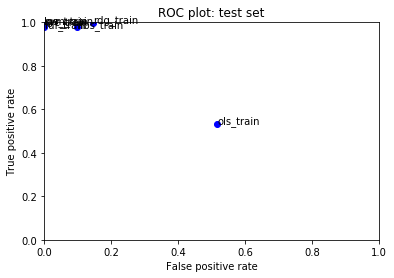

In [118]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [123]:
rdg_predictions = rdg.predict(X_train)

### let's look at some false positives:

In [124]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(rdg_predictions)):
    if (rdg_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
221
To Dayewalker – can you WP:PROVE it's original research? I've proven it isn't. DC – just calling it rubbish (which is your personal opinion that goes against WP:NEUTRAL and WP:COI) isn't a criteria for anything.
* * * * * * * * * 
229
Why'd you block me, Curps?  I seriously thought I was being hacked; half the time I switched a page, it would give me an error.  It was a simple mistake.  Why?
* * * * * * * * * 
306
No clue. That's why I made a new account.
* * * * * * * * * 
333
. Goodbye for good, then. I promised to behave, if it is not enough for you, I will not lick your feet to prove it.
* * * * * * * * * 
336
"

You know... maybe it's me... you are either the 4th or 5th person to turn this on me. The guy put ""when you buy an American car, you must afterwards have sex with your cousin, because that's what [Americans] do."" I took it off... the guy came back with a sockpuppet (its all on the Jeremy Clarkson talk page...) then I got blocked for a wee

5865
anybody ever coming across him IRL should know that
* * * * * * * * * 
6057
REDIRECT Talk:Mother (video game series)
* * * * * * * * * 
6151
User Ferret is harassing me 

He follows me around
* * * * * * * * * 
6375
You know what go ahead and block me, This is my third or four register username anyway, you can keep blocking till your hearts content but I will keep register a new username and start posting again.
* * * * * * * * * 
6406
Comeuppance 

You are going to get yours, mark my words! 188.221.144.7
* * * * * * * * * 
6494
Note
All below visible warnings are posted by a person who is obviously mentally challenged. Therefore, this talk page is of no use to me. Any discussion related to any of my edits will be honored only on the pages where it happens to be commited.
* * * * * * * * * 
6639
Alternate reality section: does not discuss the ship, but instead the plot line of the movie -  not relevent 

This should describe the ship, the diffrences and specs ect... not the plot l

10512
I would say the Toronto Star article on Mon. July 12th would be the most accurate - because their information would have come from the official police report about the incident - correcting any mis-information or initial errors about the incident.   Snopes would most likely relied on the Toronto Star Sat. copy, and not the Monday edition for their source.
* * * * * * * * * 
10538
Whereas your comment here about laziness wasn't at all personal, presumably because you're an administrator and always right? Can't you smell the hypocrisy?

I'm sorry to have brought this unpleasantness to your talk page Ealdgyth, and I won't be responding to Cirt here again.  Fatuorum
* * * * * * * * * 
10659
"
Talk, you are involved in the previous discussion, therefore please relocate your comment to the appropriate area. 87.69.177.35  "
* * * * * * * * * 
10781
Heads up

Thanks for reverting that vandalism to Mario. I know the guy who did it - he is a classmate of mine. He hates Mario and Nintendo f

correctness of Wikipedia. talk
* * * * * * * * * 
16494
"

 Wikihounding 101 

""Third, you are a reprehensible little man. You just called me a liar but at least I don't come to several pages, which in itself is against policy if not common sense, and make accusations because someone accuses you of adding information without references. That's worse than wikihounding, but it is a form of it. When you go to my talk page and make veiled accusations there, when they belong at the appropriate discussion that's clearly wikihounding. You disgust me. You represent the worst part of wikipedia: hypocrites; those who can't see their own faults but jump on others for what they perceive as faults when it's just a disagreement.""

Got a bit overheated yourself, over nothing but a little question I asked. Your provocation did not work. Your responses show you're worse than any of the malicious statements you made (quoted above) about me. Perhaps you might like to take a bit of your own medicine and

22138
"

 ""Beating around the bush"" 

having just arrived at this article i found it incredibly hard to discern what it was that appropriate technology entailed. i feel that this article could go a very long way to include a simple, single sentence summary of what appropriate technology actually is. The following line from http://lsa.colorado.edu/essence/texts/appropriate.htm was far more useful to me than the existing background, and i suggest that someone find a means to incorporate it, or something similarly ""to the point"" into the beginning of the article. I would do it myself, however as an unregistered user i do not have the confidence to go about editing the article.

""Appropriate technology is small-scale technology. It is simple enough that people can manage it directly and on a local level. Appropriate technology makes use of skills and technology that are available in a local community to supply basic human needs, such as gas and electricity, water, food, and waste disp

33397
OK, we could do that,....

We might need to add the fact that the NOAA report didn't discuss fracking, if we can find a reliable source to that effect.  —   (talk)
* * * * * * * * * 
33736
Maybe all these narcissists you talk about can just Google Kim Jong Un if they can't bear not to know what he looks like.  They certainly must know that much to find images, since they are practiced at searching for pictures of 6 year olds everyday.
* * * * * * * * * 
33768
"
This is not acceptable. It is perfectly obvious that the Anti-semitism category is being used as a second best by people who want to label people anti-semites which was all but admitted by IronDuke above. Israeli lobby organizations consistently equate anti-semitism with anti-zionism to try and scare people from criticising Israel for fear they will be labelled ""nazis"". Ahmedinejad has not made laws against Jews in Iran, he has not criticised them, ostracized them or punished them in any way for their religion or culture

38951
hey dude, do you always revert good faith edits without comment, even when requested? do you even look at what you're reverting? might i suggest that you do? 86.44.33.121
* * * * * * * * * 
39068
It would improve the articles if all the results were listed but it will be a huge task.138.162.140.52
* * * * * * * * * 
39162
blah... blah... blah... blah......
* * * * * * * * * 
39207
I'm only talking about this quote, although other lies on this article should be removed as well. 62.255.104.106
* * * * * * * * * 
39232
I'll be back...just you wait.
* * * * * * * * * 
39340
Maryester what long angry salad of letters that doesn't make a single coherent argument, and since when was the Bible a history book let alone a sholarly source? 142.151.213.12
* * * * * * * * * 
39517
No, JzG, you're lying.  Again.  The last time you tried this on, people called you on your behaviour.  You were caught banning me without reason, and then tagging an article I had created for deletion in bad faith, 

44367
I see you, Hohohahaha. Kisses to you.
I'm not kidding.
* * * * * * * * * 
44525
Look Xwomanizerx, Britney Spears does not know you.  Take your hands of your keyboard, go outside and try to find yourself a real woman.  Britney already has enough crazy fans chasing her - no wonder she started doing crazy things: getting married for 55 hours, driving a car with her son on her lap, shaving her head, getting tattoos, taking illicit substances, refusing to relinquish custody of her sons.  Crikey - how many women are 29 years old and have mommy and daddy controlling her assets because she is not capable of doing so herself.  Do her a favor, leave the poor girl alone.
* * * * * * * * * 
44734
"

First off, your baseless accusations. You accused me of bad faith. Precious. As recently as yesterday you refereed to the inclusion of Dado Prso's first name in the article (as is the case on hundreds of other sportspeople bios throughout Wiki), as a ""Serb nationalist talking point"", a ""thinly

49010
"
Then why not start an RFC on re-sysopping? Simples. If you'd done that, we wouldn't be here now. andemu 
"
* * * * * * * * * 
49151
Yes it is illegal. Look it up. Under New York law and federal law. Or do you have a source that they repealed these laws within the past few days? I should know, as my name has an umlaut. Illegal under state and federal law. Only English is allowed in the USA. You are the worst troll and stalker of wikipedia. And yes, foreign letters and words are not allowed on English wikipedia.
* * * * * * * * * 
49163
"
What Neutralhomer is doing is harrasment. 888 "
* * * * * * * * * 
49253
"

If you base an argument on a lie, you can take the argument anywhere you like.  The Patriot Act is not an ""anti-terrorism"" law.  There are parts of it that are used to battle terrorism, but that is just a part of the entire act.  You may as well say, ""The Patriot Act was passed to control illegal shipments of bananas into to the U.S. and now it is being used to track 

Blocked? Funny, I don't feel blocked. Seems I can edit anything I want. Thanks, FP. I think you have made things much simpler. Truly, I didn't expect this. I like surprises. I hope you do too.
* * * * * * * * * 
59732
why are you going to block me he is the one deleted stuff
* * * * * * * * * 
59737
"

No Need For Certian Characters
Their are some extremely insignificant characters in this artical such as ""Ami"" and ""Akane"" that shouldnt be in there. If you've seen the anime Naruto then you would know that they dont need to be in this artical as they heald very little purpose in Naruto."
* * * * * * * * * 
59930
Plagarism

The introduction to this page is nearly word for word from the Washington Post:

The Redskins and Cowboys have been regular opponents and bitter adversaries since 1960. They have experienced epic battles, nail-biting finishes and divisional and conference championships. Their rivalry over the years has come to be known as one of the greatest in sports.

We need to

64867
Stalking 
I asked you to stop bothering me.  You then posted more drivel on my talk page.  Unlike your cowardly 'running off to teacher', I'll give you fair warning - add anything else and I'll involve an admin to have you stopped.  You are an obsessive, little weirdo - go away.
* * * * * * * * * 
65244
Why are you so rude? 

Why do you keep on reverting me?
* * * * * * * * * 
65359
keep it up brother 

bolivia has faith in you brother. dont lose the fight. the family supports you.
* * * * * * * * * 
65464
"

 errors 

Windows 2000 Professional have many errors. I know, because I has Windows 2000 Professional in my computer, and... My cousin spoke me, someone worked a paper on www pages, but suddenly he overhear odd voice, and this a overheear voice spoken: ""You turn off a www pages, else you never turn off it's computer"". It's error in a translation adress, and many errors in protected. Alden(Sharon boyfriend) or talk "
* * * * * * * * * 
65519
AndyTheGrump doesn't like the Da

70426
How could you??? 

I was amazed to find out that you left the project even although your family supported you during Wikimania 2012, and while you were trying to get Ford Island to featured article class, and while  you were  heavily involved in some Wikipedia issue or another.I believe by leaving the project  you've betrayed not only Wikipedia, but also your heroic family! 208.54.5.219
* * * * * * * * * 
70706
"
With the comma, it sounds as if ""I"" am the one who is ""lying next to me"". Hehe. — · [ TALK ]  "
* * * * * * * * * 
70928
"
, tell that to John Carter and his amazing friends. Although frankly ""Nazi"" is such an aggressive personal attack that I think using it against anyone would be grounds for a sanction, even if they were explicitly advocating Holocaust denial or something, you know, actually related to the Nazi party.  (聖やや) "
* * * * * * * * * 
70970
"I'm just responding likewise.  You insist on double-talk and a lack of integrity and I'll treat you as you deser

76194
Will Beback|Will Beback]]  ·:· 16:
* * * * * * * * * 
76207
'Strongly oppose merge He is a very notable criminal. An individual page is appropriate.
* * * * * * * * * 
76282
"

Tawker: With the first sentence, your second edit to that is fine, although I saw no reason to tinker with the sentence in the first place. my mistake I just got mixed up between that and your first edit which wasn't so neutral sounding.

With the second paragraph, it's relevancy is in question, it is not notable, and it is an non-constructive edit.  Howcome you didn't bring this up in the discussion page like you are supposed to. You are on wikipedia long enough you should know this.  

Also, you added another unqualified edit to the 2008 referendums section.  We talked about this didn't we? You and I, I don't understand why you'd go ahead and insert ""independent elections administrator.""  We were talking about this for days but then you try to sneak it in the backdoor. Be upfront and reasonable, let's 

81020
This IP 
Just so you know, this is an IP that rotates among AT&T; DSL customers in Houston and possibly elsewhere; edits made from this address now are very unlikely to be being made by the same person as edits made last week. For instance, the person typing this has no idea who Kurt Shaped Box is and thinks it sucks that he got harassed. 69.154.191.30
* * * * * * * * * 
81124
PLEASE ANSWER 
WHO ARE YOU TO TELL ME WHAT TO DO? I JUST WOULD LIKE TO KNOW THE I'LL STOP.
* * * * * * * * * 
81142
and there will ALWAYS be more IP #'s than you could possibly chase down in your desperate little lives.  Learn from it.  207.237.233.142
* * * * * * * * * 
81468
Vast majority of publications state that falsetto regards to males only. Is not it similar to this matter by any chance? Why do you even mention the female falsetto in the article if everyone say it is in male only, if Miller says it is nonsense to talk about it? Not trying to provoke. Trying to understand what makes you delete the in

86540
"
Hello Phil. I was unaware I was required to be collegial. But could you please tell me what is uncollegial about including that quote? Is it the inclusion of the (sic) following a misspelling? If so I can correct brew's spelling in the quotation. But I would like to include that quote as it is representative of the bullshit that editors regularly deal with in the topic area. Could you imagine that in a dispute about where a place is an editor would say what the sources say about where that place is is an ""irrelevant straw man""? I found it unimaginable and verging on being hilarious, so I would like to include it. So, could you please tell me what is uncollegial about including the quote and further why collegiality is a requirement for what appears on a userpage? The inclusion is not a personal attack, it is not uncivil, it does not violate anything in WP:USERPAGE. It is simply showing, accurately, the views of an editor. Why would that not be allowed? nableezy - "
* * * * * 

92160
"

 Reply to ""How the Amerindians became Spanish or Hispanic"" 

Wow! You incorrectly on a great scale stated the following: 
""...neither Hispanic nor Anglo are ""racial"" terms per se while African American is.""

Just to correct you, in america, hispanic and anglo are used as racial terms. Where do you come from that you don't recognize this? Again, just fo the record, europeans view non-white south americans as hispanic. Spaniards are not considered hispanic by european standards. 

And don't let these stupid americans fool you either! At one point, they considered jews and irish to be non-white, believe it or not. So, this speaks volumes of the ignorance of americans who don't even come close to europeans in culture, arts, language, science, fashion, etc. 

."
* * * * * * * * * 
92214
Laughs* at personal attack.
* * * * * * * * * 
92313
Poor old Eric 

Oh dear so you're such a delicate soul. Didn't like me telling poor old Corbett about how much delight I am getting seeing 

97622
Today's high-quality journalism. I am scratching my head as to how to edit this article.
* * * * * * * * * 
97710
It appears that you two obviously should get along well together!.
* * * * * * * * * 
97968
Please pardon me if it's a stupid question, as I haven't really done a lot of work with categories in the past. But does that sort of change really need a CfD? I think that if I had found myself with a similar sub-cat idea, I would have just gone ahead and done it or, more likely, thrown it at a relevant project talk page to see if there were objections. Of course, maybe you weren't able to get consensus at the project, hence the post to CfD. Again, sorry if this seems stupid — as I branch out into new and different tasks, I just like to understand the thinking of people who are engaged with them more regularly. I find it helps me with my own decision-making.
* * * * * * * * * 
98084
hey wat up get back ta me
* * * * * * * * * 
98112
Lacking anyone else jumping in, I made a few

103336
"

Please do not sign your posts as  

As even you should be able to see, an account was created by someone who called themself Anonm but they ceased using that name the same day they created it last December! There is no point in using IP addresses since 1000s of people can share an IP. And like thousands of other users, I don't always use the same IP or IP Block and really have no interest in reading your arrogant, insulting comments any more than you have any interest in my ""uncivil"" ones. The only uncivil, rude, unhelpful person in these exchanged has been you.  

It doesn't matter that  

No one has any ""bizzare grudge"" against you. You're simply rude and obnoxious  the best example of what's WRONG with Wikipedia. Your comments and behavior again reveal you to be a thuggish bully. You clearly have too much time on your hands, and seem to delight in playing the petty bureaucrat, the ENFORCER OF THE RULES. 
Should you continue this sort of harrassment, you may well find y

109850
":::No. Your expanation does *not* explain why this cannot be removed. The writer's notability is not a consideration, only the quality of the source as defined by WP:RS. The first reference was not being disputed. The last reference is a multiple reference to reviews of reviews, regardless of the writer, tertiary, or worse, and a reference to a WP article, as I stated above, and not good sources. WP:RS states
""Wikipedia articles should be based mainly on reliable secondary sources. Tertiary sources such as compendia, encyclopedias, textbooks, obituaries, and other summarizing sources may be used to give overviews or summaries, but should not be used in place of secondary sources for detailed discussion"".
These references, including the one to a WP artice itself do not fit the descriptions at WP:RS and need to be removed. WP:Pseudoscience is clearly defined by WP and needs no repetition of its definition, especially, inside the same sentence and in this article. The sentence s

115349
All characters need more relevant information 

It has been months since I read this article, and reading it now I am disappointed.
All the information seems somewhat dated, and most of it needs more information, e. g. character development. I'd do this myself but I'm a lazy-butt and thought it would be better to bother your pointless lives.
* * * * * * * * * 
115577
I'm (Nettogrof) currently working to solve 1.h3 opening, because I read somewhere that 1.h3 it'S lost , but no proof.
* * * * * * * * * 
115614
"
I seriously need to calm down right now, I'm taking a break for a while!. Jack In "
* * * * * * * * * 
115645
Random Question

What are you going to or are majoring in college? -   
Library science, hopefully in digital archiving if they have it available by the time I'm finished with the general requirements for my degree. It's such a shame that so many sources aren't available on the Internet, partially due to a lack of money to get them up but also largely due to a lack

120528
Blocked 

I was blocked, but an admin was allowed to call me a weird and attack me?
* * * * * * * * * 
120636
indeed, he is not surprised that that your fascist state was repeatedly elected několirktá as the biggest problem in the path to world peace

actually, you stupid, patriotic, manipulative bastards should kill, burn, your entire floor level to the ground and even sprinkle with salt ... or one day destroy the entire world ...
* * * * * * * * * 
120801
I've corrected the climate records for the chart.  The source led to Dell Regional High School in New Jersey, not anywhere in New York City.  This was probably done so that the introduction of NYC's climate could say it lies entirely in the humid subtropical zone, with the coldest month averaging 0° C.  But the weather.com record for New York City shows the coldest month with an average high of 36 and a low of 23, averaging out to -1.3° C, placing it in the transition zone between humid subtropical and humid continental.  I w

125806
Unregistered punk think's he's so cool
* * * * * * * * * 
125811
Will do, but you have an anti-semitic problem here. I think you need to handle that...
* * * * * * * * * 
126009
To reiterate: Policies are meaningless if they are selectively enforced. GS and LGBT are protected classes, in spite of their blatant POV. Want to address that?
* * * * * * * * * 
126021
"

Hello, Turk! Please add more wikilinks to your article. thank you for your very interesting and valuable contribution. Also, please review the article one more time and take care to be 'NEUTRAL with all of the content. Cheers!   BATPHONEGROOVES "
* * * * * * * * * 
126075
I'm not going to put much stock in an opinion that lets someone in authority off the hook for ignoring valid questions.  Would you like to explain that behavior for me?
* * * * * * * * * 
126162
"
Communism is a threat to the civilized world because communists have massacred more people than all the castes of all the religions of the world put togeth

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [40]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3254, 'Neg': 28661, 'TP': 1577, 'TN': 15014, 'FP': 13647, 'FN': 1677, 'Accuracy': 0.5198496005013317, 'Precision': 0.10358644245927483, 'Recall': 0.48463429625076826, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [41]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3254, 'Neg': 28661, 'TP': 2092, 'TN': 27216, 'FP': 1445, 'FN': 1162, 'Accuracy': 0.918314272285759, 'Precision': 0.5914616906983319, 'Recall': 0.6429010448678549, 'desc': 'svm_test'}


### MODEL: logistic regression

In [42]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3254, 'Neg': 28661, 'TP': 2092, 'TN': 27125, 'FP': 1536, 'FN': 1162, 'Accuracy': 0.9154629484568385, 'Precision': 0.5766262403528115, 'Recall': 0.6429010448678549, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [43]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3254, 'Neg': 28661, 'TP': 2165, 'TN': 23602, 'FP': 5059, 'FN': 1089, 'Accuracy': 0.8073633087889707, 'Precision': 0.29969545957918053, 'Recall': 0.6653349723417332, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [44]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3254, 'Neg': 28661, 'TP': 2102, 'TN': 27169, 'FP': 1492, 'FN': 1152, 'Accuracy': 0.9171549428168573, 'Precision': 0.5848636616583194, 'Recall': 0.6459741856177013, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [45]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3254, 'Neg': 28661, 'TP': 3118, 'TN': 22865, 'FP': 5796, 'FN': 136, 'Accuracy': 0.814131286229046, 'Precision': 0.3497868521426969, 'Recall': 0.9582052858020897, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [46]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3254, 'Neg': 28661, 'TP': 1291, 'TN': 28616, 'FP': 45, 'FN': 1963, 'Accuracy': 0.937082876390412, 'Precision': 0.9663173652694611, 'Recall': 0.3967424708051629, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

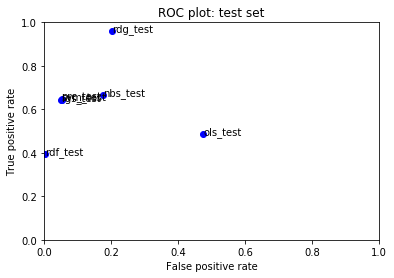

In [33]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [23]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/Users/leekuczewski/Desktop/The_New_School/Repos/VisualizeData_MachineLearning/visualizedata-ml/toxiccomments_test.csv', my_random_seed=337, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0          72          10
1          13           1
2          16           0
3          38           3
4           7           1
5          16           2
6          31           4
7           6       

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [24]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.48607375101198713


In [25]:
raw_data.head()

,id,comment_text,word_count,punc_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1


In [26]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,True
2,00013b17ad220c46,False
3,00017563c3f7919a,True
4,00017695ad8997eb,False


In [27]:
my_submission.shape

(153164, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/Users/leekuczewski/Desktop/The_New_School/Repos/VisualizeData_MachineLearning/visualizedata-ml/toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation